# <a id='toc5_'></a>[GRN using scenic+](#toc0_)
We employed the Scenic+ pipeline for GRN inference using integrated scRNA-seq and scATAC-seq data. The Scenic+ pipeline includes these steps:

1) Topic Modeling: Calculation of topics, which are coaccessibility regions, resulting in region-topic association scores.

2) Accessibility Imputation: Binarization of region-topic scores, grouping regions for each topic. This includes running differentially accessible regions across cell types and imputing access data. Notably, the average missingness in single cells drops from ~96% to ~40% after imputation, highlighting a significant source of uncertainty.

3) CisTarget: Determination of enriched motifs for each topic and differentially enriched motifs for each cell type, yielding enriched motifs and their associated genes.

4) Run Scenic+: Calculation of region-to-gene and TF to gene relationships using regression models. This step assesses the importance of regions and TFs for target genes, using imputed region counts, which could introduce errors. After calculating importance scores, only regions enriched for TF motifs are included. The pipeline then creates TF-regions-genes triples named eRegulons, resulting in a curated list of TFs, regions, and target genes.

The Scenic+ pipeline followed is based on the standard protocol as outlined in https://scenicplus.readthedocs.io/en/latest/tutorials.html.

In [ ]:
import anndata
donor_id = 'donor_0'
agg_type = ['T cells CD4+', 'NK cells', 'T regulatory cells', 'T cells CD8+'] # to be used for scenic+ pipeline
adata = anndata.read_h5ad(f'../output/scATAC/adata_{donor_id}.h5ad')
adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories(['agg_type'])
adata.obs.loc[adata.obs.cell_type.isin(agg_type), 'cell_type'] = 'agg_type'

adata.obs.cell_type.values.unique()

## <a id='toc5_1_'></a>[Topic modeling](#toc0_)

### <a id='toc5_1_1_'></a>[Create cistopic object](#toc0_)

In [12]:
# format adata to have location*obs
adata_t = adata.T
adata_t.X = adata_t.X.astype(int)

In [ ]:
from pycisTopic.cistopic_class import create_cistopic_object
path_to_blacklist= '../scenicplus/data/hg38-blacklist.v2.bed'
cistopic_obj = create_cistopic_object(
                            fragment_matrix=adata_t.X,
                            cell_names = adata_t.var.index,
                            region_names = adata_t.obs.index,
                            path_to_blacklist=path_to_blacklist,
                            project=donor_id,
                            min_frag = 10,
                            min_cell = 1,
                            split_pattern='___'
                            )
cistopic_obj.add_cell_data(adata_t.var)

2023-11-16 10:52:22,052 cisTopic     INFO     Removing blacklisted regions


2023-11-16 10:52:22,596 cisTopic     INFO     Creating CistopicObject
2023-11-16 10:52:23,411 cisTopic     INFO     Done!


In [ ]:
import pickle, os
work_dir = '../output'
pickle.dump(cistopic_obj,  open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

### <a id='toc5_1_2_'></a>[Determine number of topics (~6h using 10 cpu)](#toc0_)

In [ ]:
!python scripts/compute_topic_number.py

2023-11-15 22:59:48,237	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(run_cgs_model pid=60380) 2023-11-15 22:59:50,278 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=60373) 2023-11-15 23:00:07,423 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=60373) 2023-11-15 22:59:50,366 cisTopic     INFO     Running model with 10 topics [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=60380) 2023-11-15 23:00:14,236 cisTopic     INFO     Model with 16 topics done!
(run_cgs_model pid=60374) 2023-11-15 23:00:30,791 cisTopic     INFO     Model with 32 topics done!


Columns ['cell_type'] will be overwritten


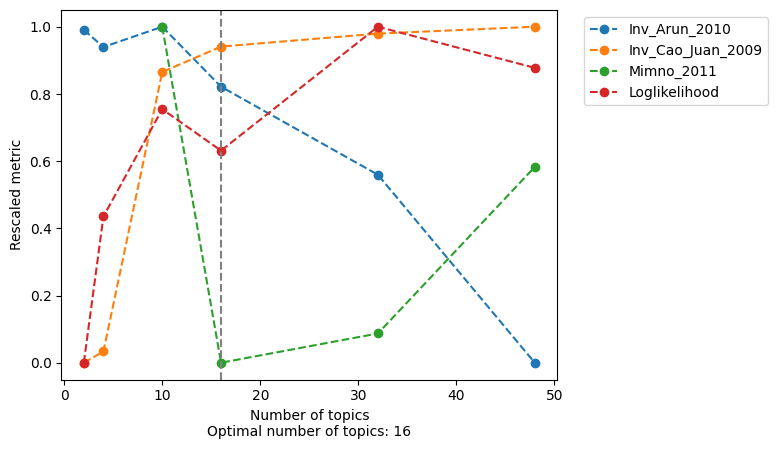

In [13]:
import pickle, os
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
cistopic_obj.add_cell_data(adata_t.var) # to fix the nan issue of cell type
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16, 
                       return_model=True, 
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

2023-12-04 14:58:18,330 cisTopic     INFO     Running UMAP


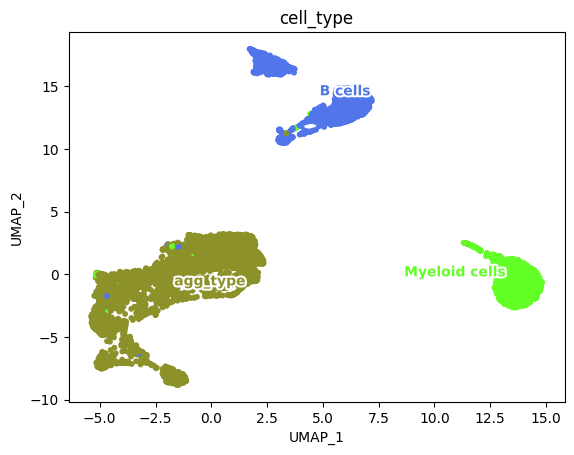

In [14]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target='cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['cell_type'])

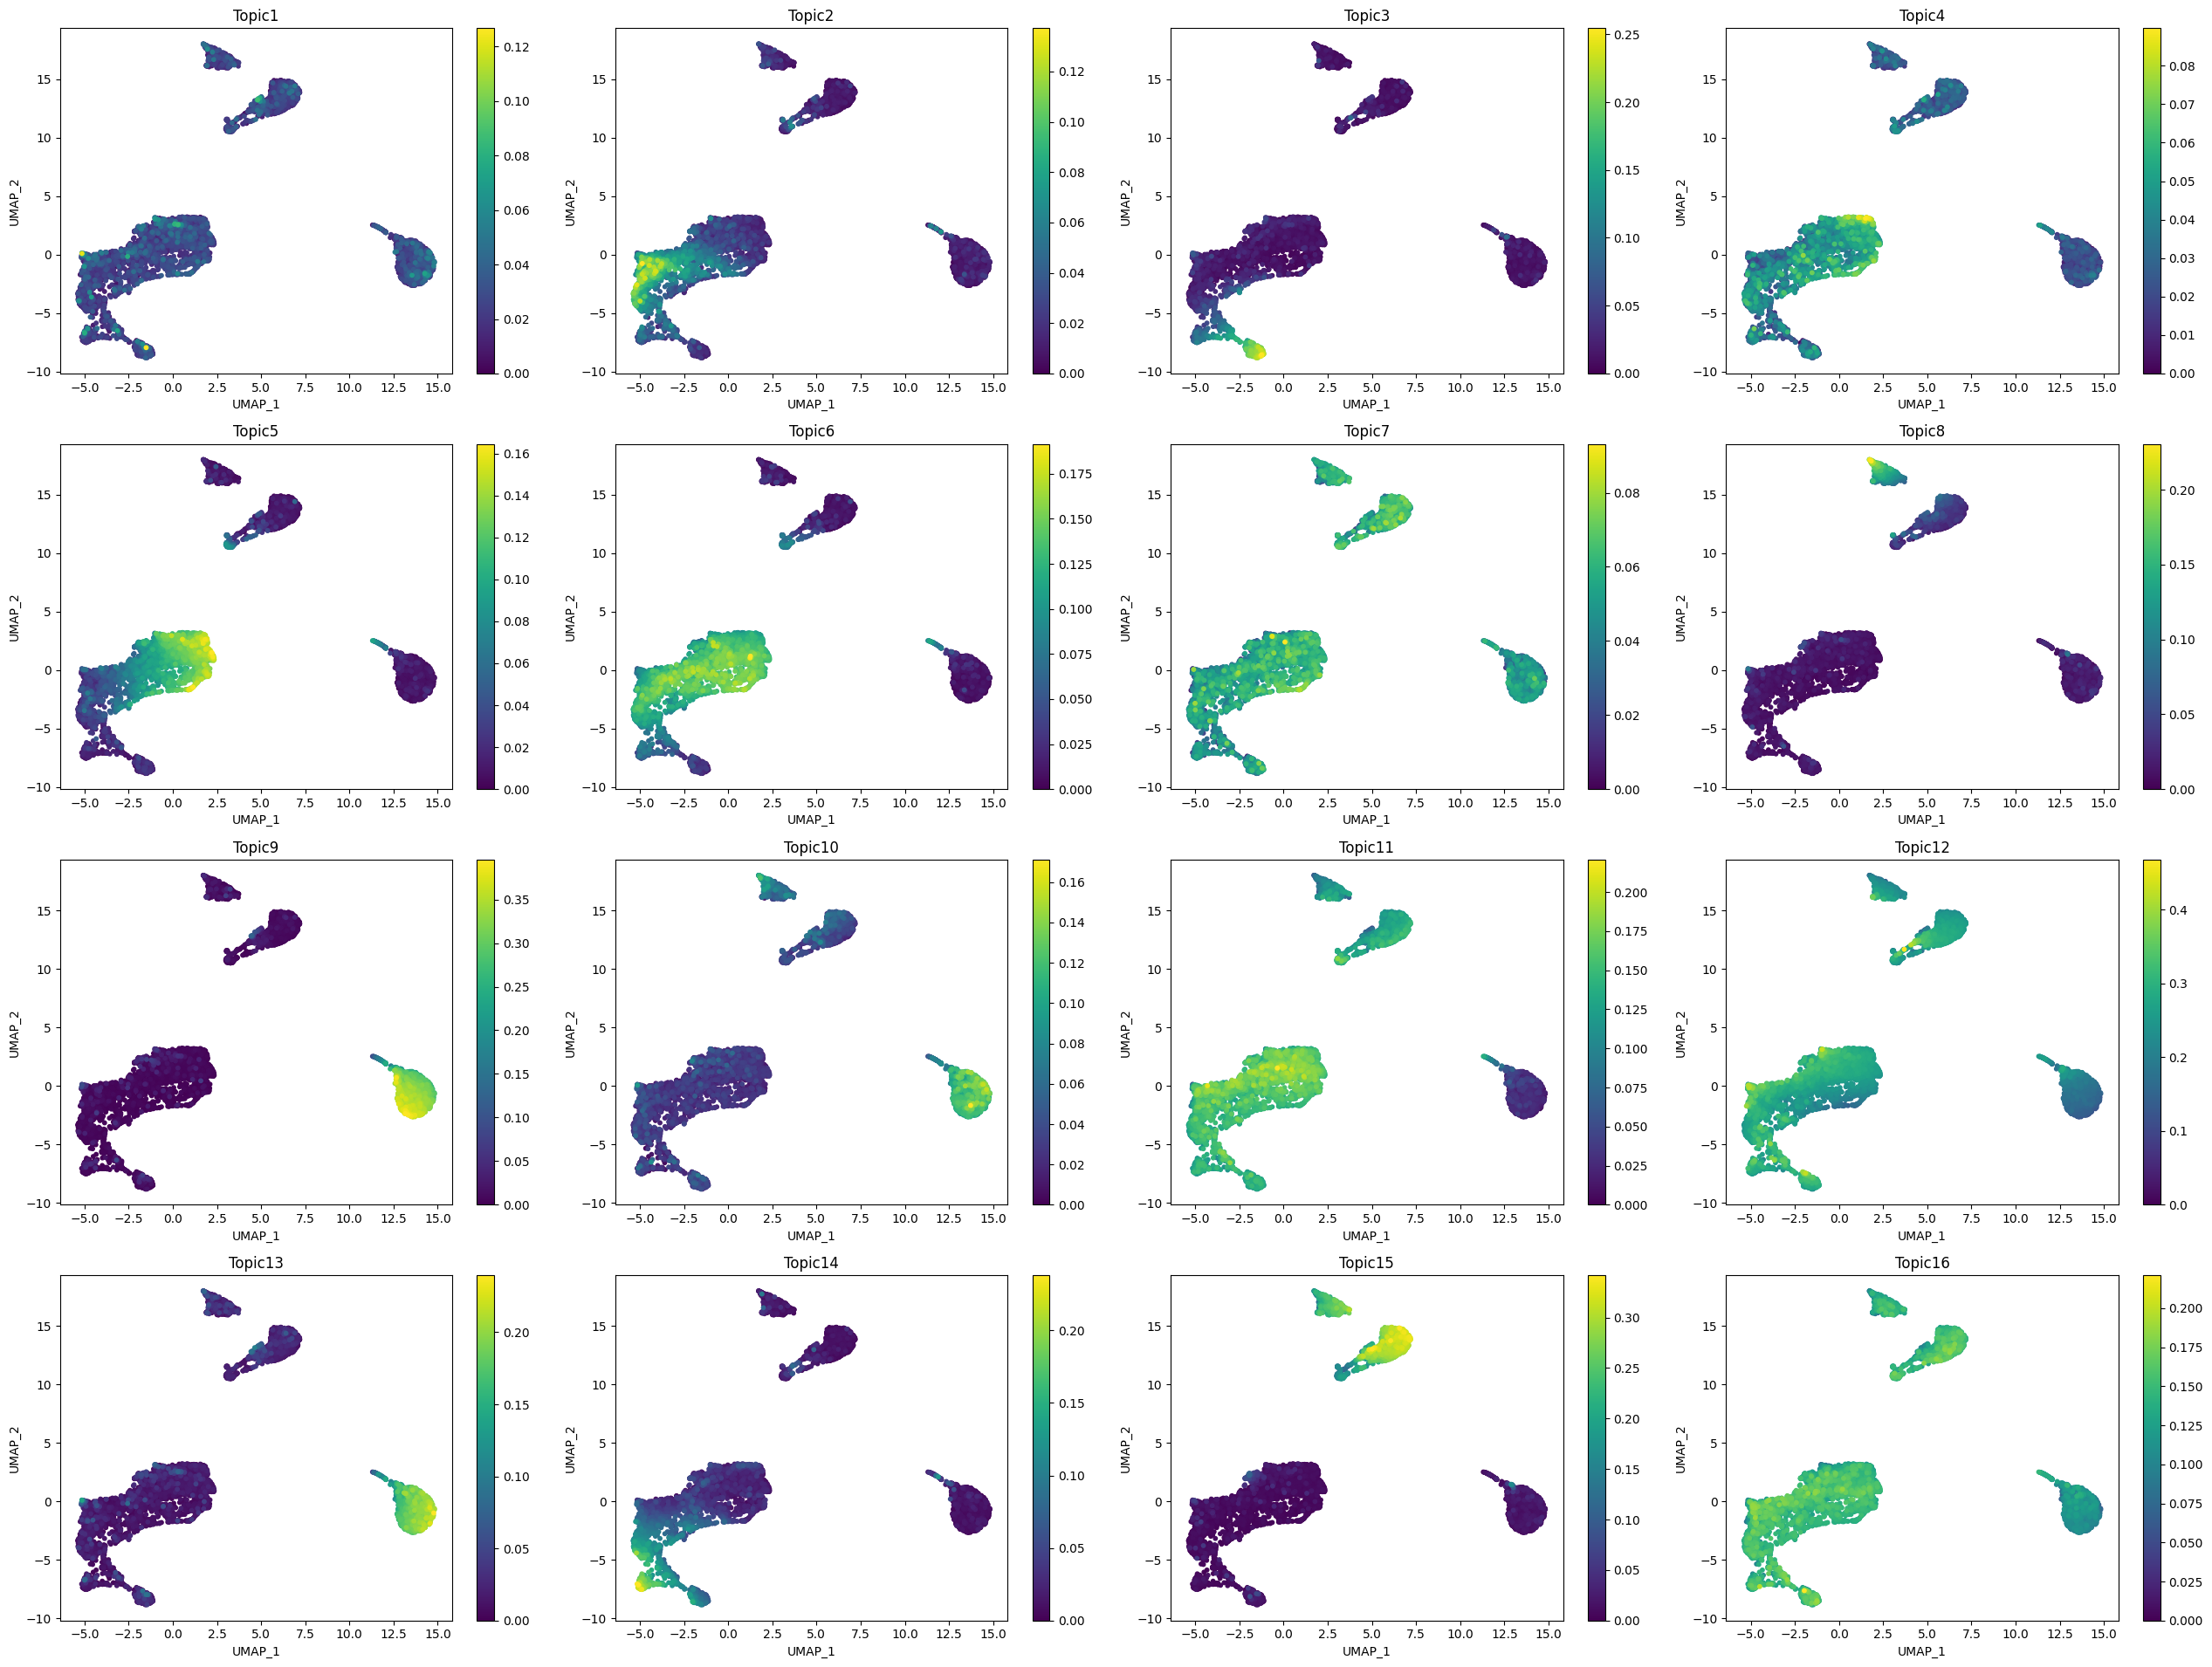

In [15]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

## <a id='toc5_2_'></a>[Accessibility imputation](#toc0_)

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu') #puts regions into topics
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [ ]:
from pycisTopic.diff_features import impute_accessibility, normalize_scores, find_highly_variable_features, find_diff_features
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='cell_type', var_features=variable_regions)

2023-11-16 15:07:02,501 cisTopic     INFO     Imputing region accessibility
2023-11-16 15:07:02,503 cisTopic     INFO     Impute region accessibility for regions 0-20000
2023-11-16 15:07:03,440 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2023-11-16 15:07:04,363 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2023-11-16 15:07:05,242 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2023-11-16 15:07:06,152 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2023-11-16 15:07:07,188 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2023-11-16 15:07:08,083 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2023-11-16 15:07:08,676 cisTopic     INFO     Done!
2023-11-16 15:07:08,684 cisTopic     INFO     Normalizing imputed data
2023-11-16 15:07:13,101 cisTopic     INFO     Done!
2023-11-16 15:07:13,116 cisTopic     INFO     Calculating mean

<Figure size 640x480 with 0 Axes>

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

## <a id='toc5_3_'></a>[Cistarget](#toc0_)

In [1]:
import pyranges as pr
from pycistarget.utils import region_names_to_coordinates
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions))

In [ ]:
# these datasets are publicly available
rankings_db = os.path.join('../scenicplus/data/', 'hg38_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join('../scenicplus/data/', 'hg38_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join('../scenicplus/data/', 'motifs-v10-nr.hgnc-m0.00001-o0.0.tbl')

In [ ]:
from scenicplus.wrappers.run_pycistarget import run_pycistarget
run_pycistarget(
    region_sets = region_sets,
    species = 'homo_sapiens',
    save_path = os.path.join(work_dir, 'scATAC/motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 40,
    _temp_dir = None,
    annotation_version = 'v10nr_clust',
    )

In [3]:
menr = dill.load(open(os.path.join('../output', 'scATAC/motifs/menr.pkl'), 'rb'))

In [7]:
menr['CTX_topics_otsu_All']['Topic1']

## <a id='toc5_4_'></a>[Scenic+ main run](#toc0_)

In [1]:
import dill
import scanpy as sc
import os

adata = sc.read_h5ad('./output/scRNA/adata_donor_0.h5ad')
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
menr = dill.load(open(os.path.join(work_dir, 'scATAC/motifs/menr.pkl'), 'rb'))

In [ ]:
from scenicplus.scenicplus_class import create_SCENICPLUS_object
import numpy as np
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    bc_transform_func = lambda x: f'{x}___donor_0' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
scplus_obj.X_EXP = np.array(scplus_obj.X_EXP.todense())
scplus_obj

### <a id='toc5_4_1_'></a>[Merge cistrome](#toc0_)
For each topic, we get the enriched motifs, pull out their associated regions, and combined it in one df for each TF. 

In [ ]:
from scenicplus.cistromes import merge_cistromes

merge_cistromes(scplus_obj)
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
            dill.dump(scplus_obj, f, protocol = -1)

### <a id='toc5_4_2_'></a>[Gene search space + region to gene relationship](#toc0_)
The method identifies the relevant regions from the TSS of a gene, spanning a range from -10 to +10 bp up to a distance of 150,000 bp. This process involves determining which regions are significant within this specified range.

For the region-to-gene relationship:

**Regression Model**: it fits a regression model to understand the relationship between regions and genes. This model helps in extracting the importance of various features (regions) in relation to the target gene.

**Correlation Analysis**: it conducts correlation analysis to determine the signs of the relationships. This analysis is crucial for understanding the nature (positive or negative) of the influence that regions have on the target genes.

The imputed region accessibility data are utilized in these regression models, providing a basis for understanding how different genomic regions might influence gene expression.

In [ ]:
from scenicplus.enhancer_to_gene import get_search_space, calculate_regions_to_genes_relationships
biomart_host = "http://sep2019.archive.ensembl.org/" 
species='hsapiens'
assembly='hg38'
upstream = [1000, 150000]
downstream = [1000, 150000]
get_search_space(scplus_obj,
                     biomart_host = biomart_host,
                     species = species,
                     assembly = assembly, 
                     upstream = upstream,
                     downstream = downstream) 
calculate_regions_to_genes_relationships(scplus_obj, 
                        ray_n_cpu = 10, 
                        _temp_dir = None,
                        importance_scoring_method = 'GBM')

In [12]:
print('number of genes in gene space: ',scplus_obj.uns['search_space'].Gene.unique().shape)
print('number of genes in region-to-gene: ', scplus_obj.uns['region_to_gene'].target.unique().shape)

number of genes in gene space:  (19013,)
number of genes in region-to-gene:  (15242,)


### <a id='toc5_4_3_'></a>[TF to gene relationship](#toc0_)
Similar to the previous step, the method uses regression models to map TF (in their gene format) to target genes. This step includes all TFs and all genes (unnecessary as it removes most of them in the next step when considering enriched motifs). 

In [ ]:
from scenicplus.TF_to_gene import calculate_TFs_to_genes_relationships
calculate_TFs_to_genes_relationships(scplus_obj, 
                        tf_file = './output/utoronto_human_tfs_v_1.01.txt',
                        ray_n_cpu = 10, 
                        method = 'GBM',
                        _temp_dir = None,
                        key= 'TF2G_adj')

In [34]:
print('number of TFs in TF2G_adj: ', scplus_obj.uns['TF2G_adj'].TF.unique().shape)
print('number of genes in TF2G_adj: ', scplus_obj.uns['TF2G_adj'].target.unique().shape)

number of TFs in TF2G_adj:  (1269,)
number of genes in TF2G_adj:  (22726,)


### <a id='toc5_4_4_'></a>[Enhancer driven regulons (~10 hours using 10 cpu)](#toc0_)
By having the importane of TFs to genes and regions to genes, in the folowing step, we also consider enriched regions and a few more processes to create eRegulons, which constains a set of TFs, regions, and targets genes.

Since this process takes a very long time, we did not use scenic+ wrapper to run all the steps but rather to run the individually. 

We did not fully understand the exact methodologies behind each individual methods in the following section. We encourage the readers to look at their documentation on scenic+.

In [ ]:
from scenicplus.grn_builder.gsea_approach import *
from scenicplus.utils import *
from scenicplus.eregulon_enrichment import *
n_cpu = 10
_temp_dir = None
region_ranking = None
gene_ranking = None
calculate_TF_eGRN_correlation = True
calculate_DEGs_DARs = True
variable = ['GEX_celltype']
save_path = f'output/scenicplus/' 

scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))
# create a GRN by connecting the previous steps with enrichment analysis
build_grn(scplus_obj,
            min_target_genes = 10,
            adj_pval_thr = 1,
            min_regions_per_gene = 0,
            quantiles = (0.85, 0.90, 0.95),
            top_n_regionTogenes_per_gene = (5, 10, 15),
            top_n_regionTogenes_per_region = (),
            binarize_using_basc = True,
            rho_dichotomize_tf2g = True,
            rho_dichotomize_r2g = True,
            rho_dichotomize_eregulon = True,
            rho_threshold = 0.05,
            keep_extended_motif_annot = True,
            merge_eRegulons = True, 
            order_regions_to_genes_by = 'importance',
            order_TFs_to_genes_by = 'importance',
            key_added = 'eRegulons',
            cistromes_key = 'Unfiltered',
            disable_tqdm = False, 
            ray_n_cpu = n_cpu,
            _temp_dir = _temp_dir)
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
    dill.dump(scplus_obj, f, protocol = -1)
print('------ saved stage 1 --------- ')
print('Formatting eGRNs')
format_egrns(scplus_obj,
                eregulons_key = 'eRegulons',
                TF2G_key = 'TF2G_adj',
                key_added = 'eRegulon_metadata')

print('Converting eGRNs to signatures')
get_eRegulons_as_signatures(scplus_obj,
                                eRegulon_metadata_key='eRegulon_metadata', 
                                key_added='eRegulon_signatures')

print('Calculating eGRNs AUC')
if region_ranking is None:
    print('Calculating region ranking')
    region_ranking = make_rankings(scplus_obj, target='region')
    with open(os.path.join(save_path,'region_ranking.pkl'), 'wb') as f:
        dill.dump(region_ranking, f, protocol = -1)
print('Calculating eGRNs region based AUC')
score_eRegulons(scplus_obj,
        ranking = region_ranking,
        eRegulon_signatures_key = 'eRegulon_signatures',
        key_added = 'eRegulon_AUC', 
        enrichment_type= 'region',
        auc_threshold = 0.05,
        normalize = False,
        n_cpu = n_cpu)
if gene_ranking is None:
    print('Calculating gene ranking')
    gene_ranking = make_rankings(scplus_obj, target='gene')
    with open(os.path.join(save_path,'gene_ranking.pkl'), 'wb') as f:
        dill.dump(gene_ranking, f, protocol = -1)
print('Calculating eGRNs gene based AUC')
score_eRegulons(scplus_obj,
        gene_ranking,
        eRegulon_signatures_key = 'eRegulon_signatures',
        key_added = 'eRegulon_AUC', 
        enrichment_type = 'gene',
        auc_threshold = 0.05,
        normalize= False,
        n_cpu = n_cpu)
print('------ saved stage 2 --------- ')
print('Calculating TF-eGRNs AUC correlation')
for var in variable:
    from scenicplus.cistromes import *
    generate_pseudobulks(scplus_obj, 
                        variable = var,
                        auc_key = 'eRegulon_AUC',
                        signature_key = 'Gene_based',
                        nr_cells = 5,
                        nr_pseudobulks = 100,
                        seed=555)
    generate_pseudobulks(scplus_obj, 
                                variable = var,
                                auc_key = 'eRegulon_AUC',
                                signature_key = 'Region_based',
                                nr_cells = 5,
                                nr_pseudobulks = 100,
                                seed=555)
    TF_cistrome_correlation(scplus_obj,
                    variable = var, 
                    auc_key = 'eRegulon_AUC',
                    signature_key = 'Gene_based',
                    out_key = var+'_eGRN_gene_based')
    TF_cistrome_correlation(scplus_obj,
                            variable = var, 
                            auc_key = 'eRegulon_AUC',
                            signature_key = 'Region_based',
                            out_key = var+'_eGRN_region_based')
                            
print('Binarizing eGRNs AUC')
binarize_AUC(scplus_obj, 
        auc_key='eRegulon_AUC',
        out_key='eRegulon_AUC_thresholds',
        signature_keys=['Gene_based', 'Region_based'],
        n_cpu=n_cpu)
      
           
with open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb') as f:
    dill.dump(scplus_obj, f, protocol = -1)

## <a id='toc5_5_'></a>[Stats of the regulatory elements](#toc0_)
We can see that the remaing regulatory elements resulted from scenic+ pipeline is only a part of the inputs, e.g. 33 left from ~1200 TFs, 7461 genes left from ~22000 genes, and ~25k left ~120k peak regions. 

In [1]:
import dill, os
import numpy as np
work_dir = '../output/'
scplus_obj = dill.load(open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'rb'))

In [2]:
print('eRegulon: ', len(scplus_obj.uns['eRegulons']), 
      ', TFs: ', scplus_obj.uns['eRegulon_metadata'].TF.unique().size,
      ', target genes: ', scplus_obj.uns['eRegulon_metadata'].Gene.unique().size,
      ', target region: ', scplus_obj.uns['eRegulon_metadata'].Region.unique().size) 

eRegulon:  103 , TFs:  33 , target genes:  7461 , target region:  25082


In [39]:
# save the net
scenicplus_grn = scplus_obj.uns['eRegulon_metadata'][['TF', 'Gene', 'TF2G_rho', 'Region']].drop_duplicates().reset_index(drop=True)
scenicplus_grn = scenicplus_grn[scenicplus_grn.TF2G_rho!=0]
scenicplus_grn.columns = ['source', 'target', 'weight', 'region']
scenicplus_grn.to_csv(f'../output/scenicplus/scenicplus.csv')

: 

In [3]:
# save TFs enriched in cistarget and remaining CIS in cistrome
cistromes = np.asarray(list(scplus_obj.uns['Cistromes']['Unfiltered'].keys()))
tfs_cistromes = np.unique(([cistrome.split('_')[0] for cistrome in cistromes]))
np.savetxt('../output/scenicplus/tfs_cistrome.txt',tfs_cistromes,  fmt='%s')

In [ ]:
# Number of TFs removed during motif enrichment analysis
all_tfs = np.loadtxt('../output/utoronto_human_tfs_v_1.01.txt', dtype=str)
tfs_cistromes = np.loadtxt('../output/scenicplus/tfs_cistrome.txt', dtype=str)
print(f'from an initial {len(all_tfs)} TFs, {len(np.intersect1d(all_tfs, tfs_cistromes))} are in cistromes')

## Second run (using loose thresholding)
min_target_genes = 0,
adj_pval_thr = 1,
min_regions_per_gene = 0,
quantiles = (0.7, 0.80, 0.90),
top_n_regionTogenes_per_gene = (10, 15, 25),
top_n_regionTogenes_per_region = (),
binarize_using_basc = True,
rho_dichotomize_tf2g = True,
rho_dichotomize_r2g = True,
rho_dichotomize_eregulon = True,
rho_threshold = 0,

## Dig into eRegulon construction  

In [42]:
SCENICPLUS_obj = scplus_obj
adj_key='TF2G_adj'
cistromes_key='Unfiltered'
region_to_gene_key='region_to_gene'

min_target_genes = 10
adj_pval_thr = 1
min_regions_per_gene = 0
quantiles = (0.85, 0.90, 0.95)
top_n_regionTogenes_per_gene = (5, 10, 15)
top_n_regionTogenes_per_region = ()
binarize_using_basc = True
rho_dichotomize_tf2g = True
rho_dichotomize_r2g = True
rho_dichotomize_eregulon = True
rho_threshold = 0.05
keep_extended_motif_annot = True
merge_eRegulons = True
order_regions_to_genes_by = 'importance'
order_TFs_to_genes_by = 'importance'
key_added = 'eRegulons'
disable_tqdm = False

keep_only_activating=False
NES_thr=0
inplace=True
ray_n_cpu=None


In [43]:
from scenicplus.grn_builder.modules import create_emodules, eRegulon, merge_emodules, RHO_THRESHOLD, TARGET_GENE_NAME

In [45]:

if not adj_key in SCENICPLUS_obj.uns.keys():
    raise ValueError(
        f'key {adj_key} not found in uns slot. Please first load TF2G adjacencies!')

print('Thresholding region to gene relationships')
relevant_tfs, e_modules = create_emodules(
    SCENICPLUS_obj=SCENICPLUS_obj,
    region_to_gene_key=region_to_gene_key,
    quantiles=quantiles,
    top_n_regionTogenes_per_gene=top_n_regionTogenes_per_gene,
    top_n_regionTogenes_per_region=top_n_regionTogenes_per_region,
    binarize_using_basc=binarize_using_basc,
    min_regions_per_gene=min_regions_per_gene,
    rho_dichotomize=rho_dichotomize_r2g,
    keep_only_activating=keep_only_activating,
    rho_threshold=rho_threshold,
    keep_extended_motif_annot=keep_extended_motif_annot,
    order_regions_to_genes_by=order_regions_to_genes_by,
    disable_tqdm=disable_tqdm,
    ray_n_cpu=ray_n_cpu,
    cistromes_key=cistromes_key)


Thresholding region to gene relationships


 21%|██▏       | 3/14 [01:06<03:56, 21.52s/it]

: 

In [ ]:

log.info('Subsetting TF2G adjacencies for TF with motif.')
TF2G_adj_relevant = SCENICPLUS_obj.uns[adj_key].loc[[
    tf in relevant_tfs for tf in SCENICPLUS_obj.uns[adj_key]['TF']]]

if ray_n_cpu is not None:
    ray.init(num_cpus=ray_n_cpu, )
    jobs = []

log.info(f'Running GSEA...')
new_e_modules = []
# dict so adjacencies matrix is only subsetted once per TF (improves performance)
TF_to_TF_adj_d = {}
tqdm_desc = 'initializing' if ray_n_cpu is not None else 'Running using single core'
for e_module in tqdm(e_modules, total=len(e_modules), desc=tqdm_desc, disable=disable_tqdm):
    TF = e_module.transcription_factor
    if TF in TF_to_TF_adj_d.keys():
        TF2G_adj = TF_to_TF_adj_d[TF]
    else:
        TF2G_adj = TF2G_adj_relevant.loc[TF2G_adj_relevant['TF'] == TF]
        TF2G_adj.index = TF2G_adj['target']
        TF_to_TF_adj_d[TF] = TF2G_adj
    if rho_dichotomize_tf2g:
        TF2G_adj_activating = TF2G_adj.loc[TF2G_adj['rho']
                                            > rho_threshold]
        TF2G_adj_repressing = TF2G_adj.loc[TF2G_adj['rho']
                                            < -rho_threshold]

        TF2G_adj_activating_ranking = pd.Series(TF2G_adj_activating[order_TFs_to_genes_by]).sort_values(ascending=False)
        TF2G_adj_repressing_ranking = pd.Series(TF2G_adj_repressing[order_TFs_to_genes_by]).sort_values(ascending=False)

        if len(TF2G_adj_activating_ranking) > 0:
            if ray_n_cpu is None:
                new_e_modules.append(
                    _run_gsea_for_e_module(
                        e_module,
                        TF2G_adj_activating_ranking,
                        gsea_n_perm,
                        frozenset(['positive tf2g'])))
            else:
                jobs.append(
                    _ray_run_gsea_for_e_module.remote(
                        e_module,
                        TF2G_adj_activating_ranking,
                        gsea_n_perm,
                        frozenset(['positive tf2g'])))

        if len(TF2G_adj_repressing_ranking) > 0:
            if ray_n_cpu is None:
                new_e_modules.append(
                    _run_gsea_for_e_module(
                        e_module,
                        TF2G_adj_repressing_ranking,
                        gsea_n_perm,
                        frozenset(['negative tf2g'])))
            else:
                jobs.append(
                    _ray_run_gsea_for_e_module.remote(
                        e_module,
                        TF2G_adj_repressing_ranking,
                        gsea_n_perm,
                        frozenset(['negative tf2g'])))
    else:
        TF2G_adj_ranking = pd.Series(TF2G_adj[order_TFs_to_genes_by]).sort_values(ascending=False)
        if len(TF2G_adj_ranking) > 0:
            if ray_n_cpu is None:
                new_e_modules.append(
                    _run_gsea_for_e_module(
                        e_module,
                        TF2G_adj_ranking,
                        gsea_n_perm,
                        frozenset([''])))
            else:
                jobs.append(
                    _ray_run_gsea_for_e_module.remote(
                        e_module,
                        TF2G_adj_ranking,
                        gsea_n_perm,
                        frozenset([''])))
if ray_n_cpu is not None:
    def to_iterator(obj_ids):
        while obj_ids:
            finished_ids, obj_ids = ray.wait(obj_ids)
            for finished_id in finished_ids:
                yield ray.get(finished_id)

    for e_module in tqdm(to_iterator(jobs),
                            total=len(jobs),
                            desc=f'Running using {ray_n_cpu} cores',
                            smoothing=0.1,
                            disable=disable_tqdm):
        new_e_modules.append(e_module)


if ray_n_cpu is not None:
    ray.shutdown()

# filter out nans
new_e_modules = [m for m in new_e_modules if not np.isnan(
    m.gsea_enrichment_score) and not np.isnan(m.gsea_pval)]

log.info(
    f'Subsetting on adjusted pvalue: {adj_pval_thr}, minimal NES: {NES_thr} and minimal leading edge genes {min_target_genes}')
# subset on adj_p_val
adj_pval = p_adjust_bh([m.gsea_pval for m in new_e_modules])
if any([np.isnan(p) for p in adj_pval]):
    Warning(
        'Something went wrong with calculating adjusted p values, early returning!')
    return new_e_modules